In [147]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

from cairosvg import svg2png
from baseline.Renderer.model import FCN
from baseline.Renderer.bezierpath import BezierPath

In [79]:
width = 128
x = torch.tensor([
    [8.3360e-02, 4.2574e-01, 1.1142e-01, 9.8395e-01, 4.6122e-01, 5.2032e-02, 9.9376e-01, 8.9807e-01, 4.0128e-01, 6.2419e-01, 6.0177e-01, 6.8766e-01, 7.3925e-01], 
    [5.0657e-01, 5.1957e-01, 9.0552e-01, 9.9895e-01, 9.9976e-01, 2.9694e-01, 9.9532e-01, 5.9672e-01, 1.0000e+00, 6.4795e-01, 6.2063e-01, 6.8359e-01, 8.8618e-01], 
    [9.4604e-01, 7.9644e-01, 9.9980e-01, 3.3091e-05, 8.9011e-02, 7.8174e-01, 9.9111e-01, 9.8194e-01, 2.5966e-01, 5.4206e-01, 3.4093e-01, 4.2826e-01, 5.1584e-01], 
    [2.0927e-01, 4.6882e-01, 3.9847e-05, 9.9999e-01, 6.6341e-01, 1.8134e-01, 4.1167e-01, 1.9733e-01, 7.8683e-01, 6.0166e-01, 1.7535e-01, 2.5377e-01, 3.4096e-01], 
    [7.5044e-01, 8.3815e-01, 3.6985e-01, 7.7639e-01, 4.2308e-01, 7.6167e-01, 4.5775e-01, 5.4750e-01, 2.2924e-01, 2.8505e-01, 3.5458e-01, 4.0749e-01, 5.0173e-01]
])

In [157]:
def decode(paths, colors, width):
    canvas = torch.zeros([1, 3, width, width])
    count = len(paths)
    
    stroke = 1 - torch.from_numpy(paths)
    stroke = stroke.view(-1, width, width, 1)
    color_stroke = stroke * colors.view(-1, 1, 1, 3)
    stroke = stroke.permute(0, 3, 1, 2)
    color_stroke = color_stroke.permute(0, 3, 1, 2)
    stroke = stroke.view(-1, count, 1, width, width)
    color_stroke = color_stroke.view(-1, count, 3, width, width)

    for i in range(count):
        canvas = canvas * (1 - stroke[:, i]) + color_stroke[:, i]
        
    output = np.transpose(canvas.numpy(), (0, 2, 3, 1))
    output = (output[0] * 255).astype('uint8')
    return cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

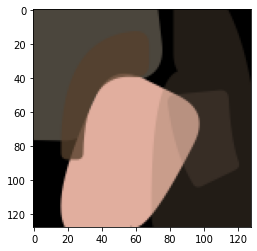

In [81]:
paths = np.array([BezierPath(f[:10], width=width).draw_svg() for f in x])
colors = x[:, -3:]
image = decode(torch.from_numpy(paths), colors, width)
plt.imshow(image)

In [ ]:
# x0, y0, x1, y1, x2, y2, z0, z2, w0, w2 
y = [0.74, 0.79, 1, 0, 0.3, 0.78, 0.5, 0.5, 1, 1]
path = BezierPath(y, width=width)

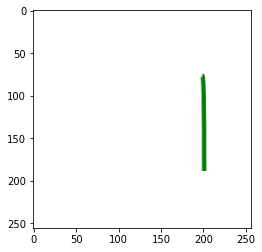

In [145]:
svgstring = "<svg viewBox=\"0 0 {} {}\" xmlns=\"http://www.w3.org/2000/svg\">".format(width * 2, width * 2)
svgstring += "<path d=\"M{},{} Q{},{} {},{}\" stroke-width=\"5\" stroke=\"green\" fill=\"none\"/>".format(path.y0, path.x0, path.y1, path.x1, path.y2, path.x2)
svgstring += "</svg>"

image = svg2png(bytestring=svgstring, write_to=None)
nparr = np.frombuffer(image, np.uint8)
canvas = cv2.imdecode(nparr, cv2.IMREAD_UNCHANGED)
plt.imshow(canvas)

<Figure size 432x288 with 0 Axes>

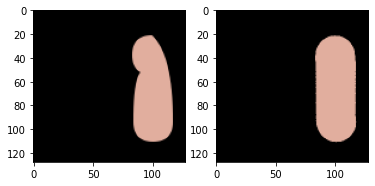

In [146]:
color = x[1,-3:]
image1 = decode(np.array([path.draw_svg()]), color.view(-1, 3), width)
image2 = decode(np.array([path.draw_opencv()]), color.view(-1, 3), width)

plt.figure()
f, ax = plt.subplots(1,2) 

ax[0].imshow(image1)
ax[1].imshow(image2)

In [148]:
Decoder = FCN()
Decoder.load_state_dict(torch.load('renderer.pkl'))

<All keys matched successfully>

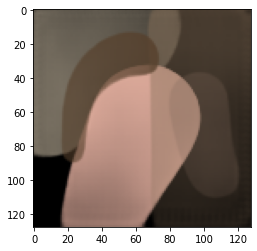

In [159]:
paths_renderer = Decoder(x[:, :10]).detach().numpy()
image = decode(paths_renderer, colors, width)
plt.imshow(image)